In [1]:
# from IPython.display import Image
# Image(filename='double logos.png')

In [2]:
# Image(filename='predicting-stock-market-with-markov/markov.png')


In [3]:
# Image(filename='predicting-stock-market-with-markov/transition-matrix.png')


In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import io, base64, os, json, re 
import pandas as pd
import numpy as np
import datetime
from random import randint

In [5]:
# load market data from Yahoo Finance (https://finance.yahoo.com/quote/%5EGSPC/history?p=%5EGSPC)

gspc_df = pd.read_csv('^GSPC.csv')
gspc_df['Date'] = pd.to_datetime(gspc_df['Date'])

cut_off_date = '2010-01-01' 
gspc_df = gspc_df[gspc_df['Date'] >= cut_off_date]


gspc_df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
1,2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2,2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
3,2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
4,2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


In [6]:
# take random sets of sequential rows 
new_set = []
for row_set in range(0, 100000):
    if row_set%2000==0: print(row_set)
    row_quant = randint(10, 30)
    row_start = randint(0, len(gspc_df)-row_quant)
    market_subset = gspc_df.iloc[row_start:row_start+row_quant]

    Close_Date = max(market_subset['Date'])
    if row_set%2000==0: print(Close_Date)
    
    # Close_Gap = (market_subset['Close'] - market_subset['Close'].shift(1)) / market_subset['Close'].shift(1)
    Close_Gap = market_subset['Close'].pct_change()
    High_Gap = market_subset['High'].pct_change()
    Low_Gap = market_subset['Low'].pct_change() 
    Volume_Gap = market_subset['Volume'].pct_change() 
    Daily_Change = (market_subset['Close'] - market_subset['Open']) / market_subset['Open']
    Outcome_Next_Day_Direction = (market_subset['Volume'].shift(-1) - market_subset['Volume'])
    
    new_set.append(pd.DataFrame({'Sequence_ID':[row_set]*len(market_subset),
                            'Close_Date':[Close_Date]*len(market_subset),
                           'Close_Gap':Close_Gap,
                           'High_Gap':High_Gap,
                           'Low_Gap':Low_Gap,
                           'Volume_Gap':Volume_Gap,
                           'Daily_Change':Daily_Change,
                           'Outcome_Next_Day_Direction':Outcome_Next_Day_Direction}))

0
2018-10-18 00:00:00
2000
2020-03-30 00:00:00
4000
2016-11-08 00:00:00
6000
2020-10-29 00:00:00
8000
2016-09-16 00:00:00
10000
2018-02-21 00:00:00
12000
2016-09-21 00:00:00
14000
2020-05-28 00:00:00
16000
2017-06-20 00:00:00
18000
2019-10-10 00:00:00
20000
2019-07-27 00:00:00
22000
2018-01-25 00:00:00
24000
2017-07-20 00:00:00
26000
2017-06-15 00:00:00
28000
2017-04-18 00:00:00
30000
2016-03-16 00:00:00
32000
2017-08-21 00:00:00
34000
2019-11-10 00:00:00
36000
2019-09-26 00:00:00
38000
2016-11-07 00:00:00
40000
2018-07-23 00:00:00
42000
2019-03-02 00:00:00
44000
2020-06-01 00:00:00
46000
2018-05-30 00:00:00
48000
2019-11-22 00:00:00
50000
2016-04-06 00:00:00
52000
2018-02-04 00:00:00
54000
2016-12-02 00:00:00
56000
2018-08-12 00:00:00
58000
2018-01-08 00:00:00
60000
2017-08-11 00:00:00
62000
2018-06-30 00:00:00
64000
2017-12-16 00:00:00
66000
2018-12-04 00:00:00
68000
2017-02-01 00:00:00
70000
2020-09-17 00:00:00
72000
2016-10-04 00:00:00
74000
2016-02-19 00:00:00
76000
2018-03-21 00:

In [7]:
len(market_subset)


14

In [8]:
new_set_df = pd.concat(new_set)
print(new_set_df.shape)
new_set_df = new_set_df.dropna(how='any') 
print(new_set_df.shape)
new_set_df.tail(20)

(1997170, 8)
(1797170, 8)


,Sequence_ID,Close_Date,Close_Gap,High_Gap,Low_Gap,Volume_Gap,Daily_Change,Outcome_Next_Day_Direction
1709,99998,2020-08-05,-0.006473,0.000706,0.000597,0.016141,-0.004894,6.484100e+08
1710,99998,2020-08-05,0.012428,0.006480,0.003436,0.160980,0.009674,-4.222900e+08
1711,99998,2020-08-05,-0.003750,-0.004233,-0.007155,-0.090304,0.004474,8.632500e+08
1712,99998,2020-08-05,0.007671,0.006537,0.005034,0.202926,0.000205,0.000000e+00
1713,99998,2020-08-05,0.000000,0.000000,0.000000,0.000000,0.000205,0.000000e+00
1714,99998,2020-08-05,0.000000,0.000000,0.000000,0.000000,0.000205,-4.736200e+08
1715,99998,2020-08-05,0.007181,0.009339,0.019958,-0.092553,0.001931,-2.197000e+07
1716,99998,2020-08-05,0.003612,0.001244,0.000560,-0.004731,0.005043,1.105500e+08
57,99999,2016-01-31,0.000532,-0.007951,0.003644,-0.098768,-0.003881,1.487720e+09
58,99999,2016-01-31,-0.011694,-0.013285,-0.028054,0.301870,-0.008981,-1.337260e+09


In [9]:
new_set_df.head()


,Sequence_ID,Close_Date,Close_Gap,High_Gap,Low_Gap,Volume_Gap,Daily_Change,Outcome_Next_Day_Direction
1042,0,2018-10-18,0.000000,0.000000,0.000000,0.000000,0.001357,-68110000.0
1043,0,2018-10-18,0.003641,0.005660,0.003580,-0.019844,-0.000581,37690000.0
1044,0,2018-10-18,-0.000397,-0.001920,0.000500,0.011203,-0.000127,196830000.0
1045,0,2018-10-18,0.000712,0.002879,0.000682,0.057859,-0.002108,-101850000.0
1046,0,2018-10-18,-0.008169,-0.006830,-0.012816,-0.028302,-0.006077,-167880000.0


In [10]:
# confirm sequence
# new_set_df[new_set_df['Close_Date'] == '1973-06-27'] {HLH, HLH, HHH, HHH, LLL, LML, LML, LLL, LHL, ...	

In [11]:
# create sequences
# simplify the data by binning values into three groups
 
# Close_Gap
new_set_df['Close_Gap_LMH'] = pd.qcut(new_set_df['Close_Gap'], 3, labels=["L", "M", "H"])

# High_Gap - not used in this example
new_set_df['High_Gap_LMH'] = pd.qcut(new_set_df['High_Gap'], 3, labels=["L", "M", "H"])

# Low_Gap - not used in this example
new_set_df['Low_Gap_LMH'] = pd.qcut(new_set_df['Low_Gap'], 3, labels=["L", "M", "H"])

# Volume_Gap
new_set_df['Volume_Gap_LMH'] = pd.qcut(new_set_df['Volume_Gap'], 3, labels=["L", "M", "H"])
 
# Daily_Change
new_set_df['Daily_Change_LMH'] = pd.qcut(new_set_df['Daily_Change'], 3, labels=["L", "M", "H"])

# new set
new_set_df = new_set_df[["Sequence_ID", 
                         "Close_Date", 
                         "Close_Gap_LMH", 
                         "Volume_Gap_LMH", 
                         "Daily_Change_LMH", 
                         "Outcome_Next_Day_Direction"]]

new_set_df['Event_Pattern'] = new_set_df['Close_Gap_LMH'].astype(str) + new_set_df['Volume_Gap_LMH'].astype(str) + new_set_df['Daily_Change_LMH'].astype(str)

In [12]:
new_set_df.tail(10)


,Sequence_ID,Close_Date,Close_Gap_LMH,Volume_Gap_LMH,Daily_Change_LMH,Outcome_Next_Day_Direction,Event_Pattern
59,99999,2016-01-31,H,L,H,-177050000.0,HLH
60,99999,2016-01-31,H,L,H,0.0,HLH
61,99999,2016-01-31,L,M,H,0.0,LMH
62,99999,2016-01-31,L,M,H,-500380000.0,LMH
63,99999,2016-01-31,L,L,L,-43440000.0,LLL
64,99999,2016-01-31,H,L,H,396100000.0,HLH
65,99999,2016-01-31,L,H,L,-61030000.0,LHL
66,99999,2016-01-31,H,L,H,804560000.0,HLH
67,99999,2016-01-31,H,H,H,0.0,HHH
68,99999,2016-01-31,L,M,H,0.0,LMH


In [13]:
new_set_df['Outcome_Next_Day_Direction'].describe()


count    1.797170e+06
mean     4.751504e+05
std      5.920865e+08
min     -4.995080e+09
25%     -1.333800e+08
50%      0.000000e+00
75%      1.388700e+08
max      4.299510e+09
Name: Outcome_Next_Day_Direction, dtype: float64

In [14]:
# reduce the set
compressed_set = new_set_df.groupby(['Sequence_ID', 
                                     'Close_Date'])['Event_Pattern'].apply(lambda x: "{%s}" % ', '.join(x)).reset_index()

print(compressed_set.shape)
compressed_set.head()

(100000, 3)


,Sequence_ID,Close_Date,Event_Pattern
0,0,2018-10-18,"{LMM, HLM, LHM, MHL, LLL, LLL, LML, LML, LHM, ..."
1,1,2017-04-02,"{LLM, LLL, LML, LML, LHH, HHH, HLM, HHH, LHM, ..."
2,2,2019-08-23,"{LHM, LHL, LHL, LLL, LML, LML, LHL, HLH, MHH, ..."
3,3,2016-10-23,"{LML, HLM, LHL, HLM, LHM, MLL, LML, LML, LLL, ..."
4,4,2020-07-24,"{LHL, LML, LML, HLH, HHH, HLH, HLL, LML, LML, ..."


In [15]:
compressed_set['Sequence_ID'].values

array([    0,     1,     2, ..., 99997, 99998, 99999])

In [16]:
#compressed_outcomes = new_set_df[['Sequence_ID', 'Close_Date', 'Outcome_Next_Day_Direction']].groupby(['Sequence_ID', 'Close_Date']).agg()

compressed_outcomes = new_set_df.groupby(['Sequence_ID', 'Close_Date'])['Outcome_Next_Day_Direction'].mean()
compressed_outcomes = compressed_outcomes.to_frame().reset_index()
print(compressed_outcomes.shape)
compressed_outcomes.describe()

(100000, 3)


,Sequence_ID,Outcome_Next_Day_Direction
count,100000.000000,1.000000e+05
mean,49999.500000,4.284018e+05
std,28867.657797,7.876343e+07
min,0.000000,-6.589012e+08
25%,24999.750000,-2.850496e+07
50%,49999.500000,4.213333e+05
75%,74999.250000,2.940375e+07
max,99999.000000,5.830725e+08


In [17]:
 
compressed_set = pd.merge(compressed_set, compressed_outcomes, on= ['Sequence_ID', 'Close_Date'], how='inner')
print(compressed_set.shape)
compressed_set.head()

(100000, 4)


,Sequence_ID,Close_Date,Event_Pattern,Outcome_Next_Day_Direction
0,0,2018-10-18,"{LMM, HLM, LHM, MHL, LLL, LLL, LML, LML, LHM, ...",1.023000e+07
1,1,2017-04-02,"{LLM, LLL, LML, LML, LHH, HHH, HLM, HHH, LHM, ...",9.351000e+06
2,2,2019-08-23,"{LHM, LHL, LHL, LLL, LML, LML, LHL, HLH, MHH, ...",1.262375e+07
3,3,2016-10-23,"{LML, HLM, LHL, HLM, LHM, MLL, LML, LML, LLL, ...",-1.221714e+07
4,4,2020-07-24,"{LHL, LML, LML, HLH, HHH, HLH, HLL, LML, LML, ...",-1.501150e+08


In [18]:
# # reduce set 

# compressed_set = new_set_df.groupby(['Sequence_ID', 'Close_Date','Outcome_Next_Day_Direction'])['Event_Pattern'].apply(lambda x: "{%s}" % ', '.join(x)).reset_index()

compressed_set['Event_Pattern'] = [''.join(e.split()).replace('{','')
                                   .replace('}','') for e in compressed_set['Event_Pattern'].values]
compressed_set.head()

,Sequence_ID,Close_Date,Event_Pattern,Outcome_Next_Day_Direction
0,0,2018-10-18,"LMM,HLM,LHM,MHL,LLL,LLL,LML,LML,LHM,LHM,LHL,LH...",1.023000e+07
1,1,2017-04-02,"LLM,LLL,LML,LML,LHH,HHH,HLM,HHH,LHM,LMM",9.351000e+06
2,2,2019-08-23,"LHM,LHL,LHL,LLL,LML,LML,LHL,HLH,MHH,HLH,LLL,LM...",1.262375e+07
3,3,2016-10-23,"LML,HLM,LHL,HLM,LHM,MLL,LML,LML,LLL,HHM,HHM,LL...",-1.221714e+07
4,4,2020-07-24,"LHL,LML,LML,HLH,HHH,HLH,HLL,LML,LML,LML,HHH,LL...",-1.501150e+08


In [19]:
# # use last x days of data for validation
# compressed_set_validation = compressed_set[compressed_set['Close_Date'] >= datetime.datetime.now() 
#                                            - datetime.timedelta(days=90)] # Sys.Date()-90 

# compressed_set_validation.shape

In [20]:
compressed_set_validation = compressed_set.tail(90)
compressed_set_validation.columns

Index(['Sequence_ID', 'Close_Date', 'Event_Pattern',
       'Outcome_Next_Day_Direction'],
      dtype='object')

In [21]:
compressed_set_validation['Sequence_ID'].values

array([99910, 99911, 99912, 99913, 99914, 99915, 99916, 99917, 99918,
       99919, 99920, 99921, 99922, 99923, 99924, 99925, 99926, 99927,
       99928, 99929, 99930, 99931, 99932, 99933, 99934, 99935, 99936,
       99937, 99938, 99939, 99940, 99941, 99942, 99943, 99944, 99945,
       99946, 99947, 99948, 99949, 99950, 99951, 99952, 99953, 99954,
       99955, 99956, 99957, 99958, 99959, 99960, 99961, 99962, 99963,
       99964, 99965, 99966, 99967, 99968, 99969, 99970, 99971, 99972,
       99973, 99974, 99975, 99976, 99977, 99978, 99979, 99980, 99981,
       99982, 99983, 99984, 99985, 99986, 99987, 99988, 99989, 99990,
       99991, 99992, 99993, 99994, 99995, 99996, 99997, 99998, 99999])

In [22]:
compressed_set = compressed_set[compressed_set['Close_Date'] < datetime.datetime.now() 
                                           - datetime.timedelta(days=90)]  
compressed_set.shape

(100000, 4)

In [23]:
list(compressed_set)


['Sequence_ID', 'Close_Date', 'Event_Pattern', 'Outcome_Next_Day_Direction']

In [24]:
# drop date field
compressed_set = compressed_set[['Sequence_ID', 'Event_Pattern','Outcome_Next_Day_Direction']]
compressed_set_validation = compressed_set_validation[['Sequence_ID', 'Event_Pattern','Outcome_Next_Day_Direction']]

##Keep big moves only and build outcome variable

In [25]:
compressed_set['Outcome_Next_Day_Direction'].describe()

count    1.000000e+05
mean     4.284018e+05
std      7.876343e+07
min     -6.589012e+08
25%     -2.850496e+07
50%      4.213333e+05
75%      2.940375e+07
max      5.830725e+08
Name: Outcome_Next_Day_Direction, dtype: float64

In [26]:
print(len(compressed_set['Outcome_Next_Day_Direction']))
len(compressed_set[abs(compressed_set['Outcome_Next_Day_Direction']) > 10000000])

100000


79278

In [27]:
# keep only keep big/interesting moves 
print('all moves:', len(compressed_set))
compressed_set = compressed_set[abs(compressed_set['Outcome_Next_Day_Direction']) > 10000000]
compressed_set['Outcome_Next_Day_Direction'] = np.where((compressed_set['Outcome_Next_Day_Direction'] > 0), 1, 0)
compressed_set_validation['Outcome_Next_Day_Direction'] = np.where((compressed_set_validation['Outcome_Next_Day_Direction'] > 0), 1, 0)
print('big moves only:', len(compressed_set))

all moves: 100000
big moves only: 79278


In [28]:
compressed_set.head()


,Sequence_ID,Event_Pattern,Outcome_Next_Day_Direction
0,0,"LMM,HLM,LHM,MHL,LLL,LLL,LML,LML,LHM,LHM,LHL,LH...",1
2,2,"LHM,LHL,LHL,LLL,LML,LML,LHL,HLH,MHH,HLH,LLL,LM...",1
3,3,"LML,HLM,LHL,HLM,LHM,MLL,LML,LML,LLL,HHM,HHM,LL...",0
4,4,"LHL,LML,LML,HLH,HHH,HLH,HLL,LML,LML,LML,HHH,LL...",0
7,7,"HLM,LHM,HHM,LLM,LLM,LMM,LMM,HLH",1


In [29]:
# create two data sets - won/not won
compressed_set_pos = compressed_set[compressed_set['Outcome_Next_Day_Direction']==1][['Sequence_ID', 'Event_Pattern']]
print(compressed_set_pos.shape)
compressed_set_neg = compressed_set[compressed_set['Outcome_Next_Day_Direction']==0][['Sequence_ID', 'Event_Pattern']]
print(compressed_set_neg.shape)

(39743, 2)
(39535, 2)


In [30]:
flat_list = [item.split(',') for item in compressed_set['Event_Pattern'].values ]
unique_patterns = ','.join(str(r) for v in flat_list for r in v)
unique_patterns = list(set(unique_patterns.split(',')))
len(unique_patterns)

26

In [31]:
compressed_set['Outcome_Next_Day_Direction'].head()       


0    1
2    1
3    0
4    0
7    1
Name: Outcome_Next_Day_Direction, dtype: int64

Build the markov transition grid

In [32]:
compressed_set_validation['Sequence_ID'].values

array([99910, 99911, 99912, 99913, 99914, 99915, 99916, 99917, 99918,
       99919, 99920, 99921, 99922, 99923, 99924, 99925, 99926, 99927,
       99928, 99929, 99930, 99931, 99932, 99933, 99934, 99935, 99936,
       99937, 99938, 99939, 99940, 99941, 99942, 99943, 99944, 99945,
       99946, 99947, 99948, 99949, 99950, 99951, 99952, 99953, 99954,
       99955, 99956, 99957, 99958, 99959, 99960, 99961, 99962, 99963,
       99964, 99965, 99966, 99967, 99968, 99969, 99970, 99971, 99972,
       99973, 99974, 99975, 99976, 99977, 99978, 99979, 99980, 99981,
       99982, 99983, 99984, 99985, 99986, 99987, 99988, 99989, 99990,
       99991, 99992, 99993, 99994, 99995, 99996, 99997, 99998, 99999])

In [33]:
# build the markov transition grid
def build_transition_grid(compressed_grid, unique_patterns):
    # build the markov transition grid

    patterns = []
    counts = []
    for from_event in unique_patterns:

        # how many times 
        for to_event in unique_patterns:
            pattern = from_event + ',' + to_event # MMM,MlM

            ids_matches = compressed_grid[compressed_grid['Event_Pattern'].str.contains(pattern)]
            found = 0
            if len(ids_matches) > 0:
                Event_Pattern = '---'.join(ids_matches['Event_Pattern'].values)
                found = Event_Pattern.count(pattern)
            patterns.append(pattern)
            counts.append(found)

    # create to/from grid
    grid_Df = pd.DataFrame({'pairs':patterns, 'counts': counts})
    

    #grid_Df['x'], grid_Df['y'] = grid_Df['pairs'].str.split(',', 1).str
    #grid_Df[['x', 'y']] = grid_Df['pairs'].str.split(',', 1, expand=True)
    # Assuming 'pairs' column contains strings like 'x,y'
    grid_Df[['x', 'y']] = grid_Df['pairs'].str.split(',', n=1, expand=True)


    grid_Df.head()

    grid_Df = grid_Df.pivot(index='x', columns='y', values='counts')

    grid_Df.columns= [col for col in grid_Df.columns]
    #del grid_Df.index.name

    # replace all NaN with zeros
    grid_Df.fillna(0, inplace=True)
    grid_Df.head()

    #grid_Df.rowSums(transition_dataframe) 
    grid_Df = grid_Df / grid_Df.sum(1)
    return (grid_Df)


In [34]:
grid_pos = build_transition_grid(compressed_set_pos, unique_patterns) 
grid_neg = build_transition_grid(compressed_set_neg, unique_patterns)

In [35]:
grid_neg.head()


,HHH,HHL,HHM,HLH,HLL,HLM,HMH,HML,HMM,LHH,...,LML,LMM,MHH,MHL,MHM,MLH,MLL,MLM,MMH,MMM
x,,,,,,,,,,,,,,,,,,,,,
HHH,0.088711,0.070293,0.130552,0.102024,0.111986,0.129475,0.03316,0.000000,0.000000,0.117789,...,0.007470,0.002003,0.000000,0.250382,0.027830,0.000000,0.150733,0.082873,NaN,0.0
HHL,0.006905,0.000000,0.000000,0.005689,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.007967,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.0
HHM,0.012929,0.000000,0.060768,0.025086,0.000000,0.048509,0.00000,0.859857,0.121049,0.000000,...,0.016403,0.077072,0.384615,0.000000,0.123023,0.163522,0.000000,0.158993,NaN,0.0
HLH,0.167707,0.463877,0.121571,0.103814,0.118708,0.067005,0.00000,0.000000,0.168124,0.000000,...,0.011077,0.000000,0.328158,0.305046,0.110373,0.226746,0.000000,0.207665,NaN,0.0
HLL,0.008698,0.000000,0.013733,0.016736,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.041383,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.0


In [36]:
grid_pos.head()


,HHH,HHL,HHM,HLH,HLL,HLM,HMH,HML,HMM,LHH,...,LML,LMM,MHH,MHL,MHM,MLH,MLL,MLM,MMH,MMM
x,,,,,,,,,,,,,,,,,,,,,
HHH,0.103805,0.109557,0.172213,0.077017,0.185781,0.166432,0.182331,0.000000,0.000000,0.133544,...,0.015119,0.006732,0.000000,0.077451,0.139154,0.000000,0.150279,0.052475,0.0,0.0
HHL,0.018893,0.000000,0.000000,0.015878,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.002274,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
HHM,0.041732,0.000000,0.108095,0.052419,0.000000,0.028367,0.000000,1.108046,0.133937,0.000000,...,0.007334,0.054887,0.085954,0.000000,0.126136,0.193203,0.000000,0.158819,0.0,0.0
HLH,0.130973,0.342424,0.133376,0.067347,0.014219,0.045696,0.000000,0.000000,0.069557,0.000000,...,0.013267,0.000000,0.199161,0.007843,0.021995,0.067338,0.000000,0.102071,0.0,0.0
HLL,0.014070,0.000000,0.007388,0.003257,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.023567,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0


In [37]:
grid_pos.columns

Index(['HHH', 'HHL', 'HHM', 'HLH', 'HLL', 'HLM', 'HMH', 'HML', 'HMM', 'LHH',
       'LHL', 'LHM', 'LLH', 'LLL', 'LLM', 'LMH', 'LML', 'LMM', 'MHH', 'MHL',
       'MHM', 'MLH', 'MLL', 'MLM', 'MMH', 'MMM'],
      dtype='object')

In [38]:
# compressed_set_validation[compressed_set_validation['Sequence_ID' == seq_id]]

In [39]:
compressed_set_validation['Sequence_ID'].values

array([99910, 99911, 99912, 99913, 99914, 99915, 99916, 99917, 99918,
       99919, 99920, 99921, 99922, 99923, 99924, 99925, 99926, 99927,
       99928, 99929, 99930, 99931, 99932, 99933, 99934, 99935, 99936,
       99937, 99938, 99939, 99940, 99941, 99942, 99943, 99944, 99945,
       99946, 99947, 99948, 99949, 99950, 99951, 99952, 99953, 99954,
       99955, 99956, 99957, 99958, 99959, 99960, 99961, 99962, 99963,
       99964, 99965, 99966, 99967, 99968, 99969, 99970, 99971, 99972,
       99973, 99974, 99975, 99976, 99977, 99978, 99979, 99980, 99981,
       99982, 99983, 99984, 99985, 99986, 99987, 99988, 99989, 99990,
       99991, 99992, 99993, 99994, 99995, 99996, 99997, 99998, 99999])

In [40]:
def safe_log(x,y):
   try:
      lg = np.log(x/y)
   except:
      lg = 0
   return lg

# predict on out of sample data
actual = []
predicted = []
for seq_id in compressed_set_validation['Sequence_ID'].values:
    patterns = compressed_set_validation[compressed_set_validation['Sequence_ID'] == seq_id]['Event_Pattern'].values[0].split(',')
    pos = []
    neg = []
    log_odds = []
    
    for id in range(0, len(patterns)-1):
        # get log odds
        # logOdds = log(tp(i,j) / tn(i,j)
        if (patterns[id] in list(grid_pos) and patterns[id+1] in list(grid_pos) and patterns[id] in list(grid_neg) and patterns[id+1] in list(grid_neg)):
                
            numerator = grid_pos[patterns[id]][patterns[id+1]]
            denominator = grid_neg[patterns[id]][patterns[id+1]]
            if (numerator == 0 and denominator == 0):
                log_value =0
            elif (denominator == 0):
                log_value = np.log(numerator / 0.00001)
            elif (numerator == 0):
                log_value = np.log(0.00001 / denominator)
            else:
                log_value = np.log(numerator/denominator)
        else:
            log_value = 0
        
        log_odds.append(log_value)
        
        pos.append(numerator)
        neg.append(denominator)
      
    print('outcome:', compressed_set_validation[compressed_set_validation['Sequence_ID']==seq_id]['Outcome_Next_Day_Direction'].values[0])
    print(sum(pos)/sum(neg))
    print(sum(log_odds))

    actual.append(compressed_set_validation[compressed_set_validation['Sequence_ID']==seq_id]['Outcome_Next_Day_Direction'].values[0])
    predicted.append(sum(log_odds))

from sklearn.metrics import confusion_matrix

confusion_matrix(actual, [1 if p > 0 else 0 for p in predicted])


outcome: 1
1.1377041889241033
4.51797224349523
outcome: 0
1.0106318170924933
0.5204826444077029
outcome: 0
0.9981218089562376
1.040359634106495
outcome: 0
1.06051476126996
2.7734043634970265
outcome: 1
1.1635654223079208
1.8749993246943661
outcome: 1
1.0214459095164443
4.02549265948994
outcome: 0
0.94309394637469
-1.3701589630161608
outcome: 0
0.9455004333210387
-1.6323917822510592
outcome: 0
0.9470725369708153
-0.9754294225281099
outcome: 0
0.9807986963460689
0.08525618877053942
outcome: 1
1.0901025595112939
4.051481528294573
outcome: 0
0.9794424957855224
-0.15746096035493096
outcome: 1
1.0627443635300724
-0.3111493785079613
outcome: 1
1.115093694316922
2.519243083555144
outcome: 0
0.9916117335327234
-0.6236254520962868
outcome: 1
1.1092022910727093
2.981228036182927
outcome: 1
1.110644589912119
1.8212990132160334
outcome: 0
1.00967094549927
0.3700647349459686
outcome: 0
1.0420866554867894
1.9711914871939
outcome: 0
0.9484695514550874
-2.0014489650445206
outcome: 0
1.0180313372314491


array([[23, 26],
       [11, 30]])

In [41]:
from sklearn.metrics import accuracy_score
score = accuracy_score(actual, [1 if p > 0 else 0 for p in predicted])
print('Accuracy:', round(score * 100,2), '%')

Accuracy: 58.89 %


In [42]:
import seaborn as sns
cm = confusion_matrix(actual, [1 if p > 0 else 0 for p in predicted])
cm

array([[23, 26],
       [11, 30]])

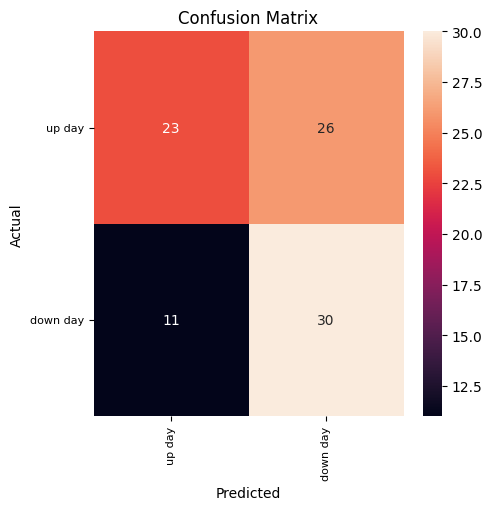

In [43]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, ax = ax, fmt='g')

ax.set_title('Confusion Matrix') 
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

ax.xaxis.set_ticklabels(['up day','down day'])
ax.yaxis.set_ticklabels(['up day','down day'])
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = 8)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, fontsize = 8)  
plt.show()